In [1]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/NBS_project/'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.getcwd()

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

from src.config import Config
from src.main import create_MDs,create_ESP
import src.baseline as baseline
import src.NBS as NBS
import src.model as model
import numpy as np
import matplotlib.pyplot as plt


项目路径设置为: c:\Users\Barytes\Desktop\NBS_project


In [2]:
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "test.json")
config = Config(CONFIG_PATH)

In [5]:
# Experiment 1: Performance of Proposed Algorithm

# num_mds = [10, 20, 30, 40, 50]

lambda0 = [50, 75, 100]
sw_uni, sw_pro, sw_non, sw_con, sw_rev, sw_gre, sw_swm, sw_admm = [],[],[],[],[],[],[],[]
Dm_uni, Dm_pro, Dm_non, Dm_con, Dm_rev, Dm_gre, Dm_swm, Dm_admm = [],[],[],[],[],[],[],[]
baselines = ['Uni', 'Pro', 'Non', 'Con', 'Opt', 'ADMM']
for l0 in lambda0:
  config.params["lambda0"] = l0
  print(f"=====Lambda 0: {l0}=====")
  
  seed = 42
  MDs = create_MDs(config, seed=seed)
  esp = create_ESP(config, seed=seed)
  # np.random.shuffle(MDs)  # Shuffle the MDs
  # for md in MDs[:n]:
  #   print(md.param)
  # print(esp.param)

  T = 20
  N = len(MDs)
  lam_uni, p_uni, r_uni, Dmax_uni = np.zeros(N),np.zeros(N),np.zeros(N),0
  for _ in range(T):
      l,p,r,d = baseline.uniform_baseline(esp, MDs,43)
      lam_uni += l
      p_uni += p
      r_uni += r
      Dmax_uni += d
  lam_uni, p_uni, r_uni, Dmax_uni = lam_uni/T, p_uni/T, r_uni/T, Dmax_uni/T
  print(f"Uniform Baseline: SW={model.social_welfare(esp, MDs, lam_uni, p_uni)}, Dmax={Dmax_uni}")

  lam_pro, p_pro, r_pro, Dmax_pro = np.zeros(N),np.zeros(N),np.zeros(N),0
  for _ in range(T):
      l,p,r,d = baseline.proportional_baseline(esp,MDs,43)
      lam_pro += l
      p_pro += p
      r_pro += r
      Dmax_pro += d
  lam_pro, p_pro, r_pro, Dmax_pro = lam_pro/T, p_pro/T, r_pro/T, Dmax_pro/T
  print(f"Proportional Baseline: SW={model.social_welfare(esp, MDs, lam_pro, p_pro)}, Dmax={Dmax_pro}")

  lam_non, p_non, r_non, Dmax_non = baseline.non_cooperative_baseline(esp,MDs)
  print(f"Non-Cooperative Baseline: SW={model.social_welfare(esp, MDs, lam_non, p_non)}, Dmax={Dmax_non}")
  lam_con, p_con, r_con, Dmax_con = baseline.contract_baseline(esp,MDs)
  print(f"Contract Baseline: SW={model.social_welfare(esp, MDs, lam_con, p_con)}, Dmax={Dmax_con}")
  # lam_rev, p_rev, r_rev, Dmax_rev = baseline.reverse_auction_baseline(esp,MDs,True)
  # print(lam_rev, p_rev, r_rev, Dmax_rev)
  # print(f"Reverse Auction Baseline: SW={model.social_welfare(esp, MDs, lam_rev, p_rev)}, Dmax={Dmax_rev}")
  # lam_gre, p_gre, r_gre, Dmax_gre = baseline.greedy_heuristic_baseline(esp,MDs)
  # print(lam_gre, p_gre, r_gre, Dmax_gre)
  # print(f"Greedy Heuristic Baseline: SW={model.social_welfare(esp, MDs, lam_gre, p_gre)}, Dmax={Dmax_gre}")
  lam_swm, p_swm, Dmax_swm = baseline.social_welfare_maximization(esp, MDs)
  print(f"SWM Baseline: SW={model.social_welfare(esp, MDs, lam_swm, p_swm)}, Dmax={Dmax_swm}")
  lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
  r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
  print(f"ADMM Baseline: SW={model.social_welfare(esp, MDs, lamb_admm, p_admm)}, Dmax={Dmax_admm}")

  sw_uni.append(model.social_welfare(esp, MDs, lam_uni, p_uni))
  sw_pro.append(model.social_welfare(esp, MDs, lam_pro, p_pro))
  sw_non.append(model.social_welfare(esp, MDs, lam_non, p_non))
  sw_con.append(model.social_welfare(esp, MDs, lam_con, p_con))
  sw_rev.append(0)  # Placeholder for reverse auction
  sw_gre.append(0)  # Placeholder for greedy heuristic
  # sw_rev.append(model.social_welfare(esp, MDs, lam_rev, p_rev))
  # sw_gre.append(model.social_welfare(esp, MDs, lam_gre, p_gre))
  sw_swm.append(model.social_welfare(esp, MDs, lam_swm, p_swm))
  sw_admm.append(model.social_welfare(esp, MDs, lamb_admm, p_admm))
  Dm_uni.append(Dmax_uni)
  Dm_pro.append(Dmax_pro)
  Dm_non.append(Dmax_non)
  Dm_con.append(Dmax_con)
  Dm_rev.append(0)  # Placeholder for reverse auction
  Dm_gre.append(0)  # Placeholder for greedy heuristic
  # Dm_rev.append(Dmax_rev)
  # Dm_gre.append(Dmax_gre)
  Dm_swm.append(Dmax_swm)
  Dm_admm.append(Dmax_admm)
  print("===================")
sw = [sw_uni, sw_pro, sw_non, sw_con, sw_swm, sw_admm]
Dm = [Dm_uni, Dm_pro, Dm_non, Dm_con, Dm_swm, Dm_admm]


=====Lambda 0: 50=====
Uniform Baseline: SW=-15.182456699577145, Dmax=0.8412513387299402
Proportional Baseline: SW=-16.00159907766566, Dmax=0.8446745071210608
Non-Cooperative Baseline: SW=78.00975125532959, Dmax=0.7287873834395884
求解失败：2 : `xtol` termination condition is satisfied.
Contract Baseline: SW=47.28408140716021, Dmax=0.2246974056168332
SWM Baseline: SW=85.61489504282376, Dmax=0.3921583325805941
ADMM Baseline: SW=85.57419742825635, Dmax=0.392282928019638
=====Lambda 0: 75=====
Uniform Baseline: SW=31.564108567967267, Dmax=0.8447685704359387
Proportional Baseline: SW=30.226718556908722, Dmax=0.8499578413469584
Non-Cooperative Baseline: SW=122.05213926702004, Dmax=0.7794108266548168
求解失败：2 : `xtol` termination condition is satisfied.
Contract Baseline: SW=97.50990662171014, Dmax=0.08968510900010847
SWM Baseline: SW=133.04725933132218, Dmax=0.4092565579922487
ADMM Baseline: SW=133.0147612701629, Dmax=0.409401635864242
=====Lambda 0: 100=====
Uniform Baseline: SW=78.1169478034027,

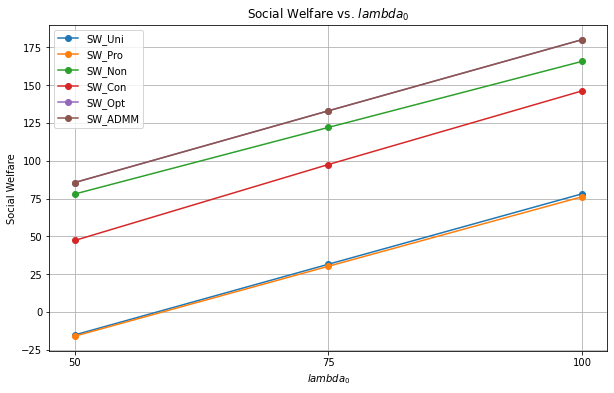

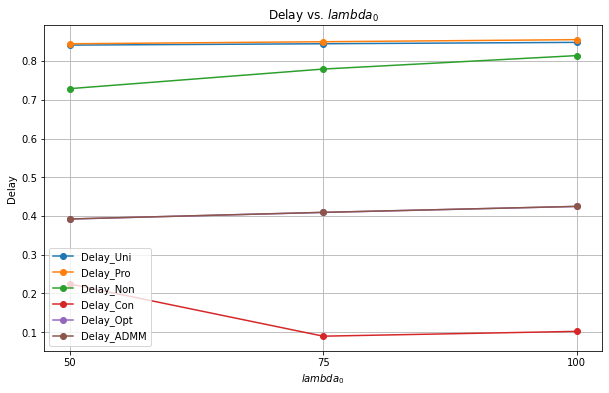

In [6]:
plt.figure(figsize=(10, 6)) # 设置图的大小
for i, data in enumerate(sw):
    plt.plot(lambda0, data, marker='o', label=f'SW_{baselines[i]}')

plt.title('Social Welfare vs. $lambda_0$')
plt.xlabel('$lambda_0$')
plt.ylabel('Social Welfare')
plt.xticks(lambda0) # 确保 N 值在横轴上清晰显示
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6)) # 设置图的大小
for i, data in enumerate(Dm):
    plt.plot(lambda0, data, marker='o', label=f'Delay_{baselines[i]}')

plt.title('Delay vs. $lambda_0$')
plt.xlabel('$lambda_0$')
plt.ylabel('Delay')
plt.xticks(lambda0) # 确保 N 值在横轴上清晰显示
plt.grid(True)
plt.legend()
plt.show()

In [5]:
  # for md in MDs[:n]:
  #   print(md.param)
print(esp.param)

{'lambda0': 70, 'D0': 1, 'theta': 2, 'o': 3, 'omega_0': 2, 's': 0.1, 'l': 0.8}


In [ ]:
# Experiment 2: Comparison of NBS and Non-Cooperative

In [ ]:
# Experiment 3: Impact of Bargaining Power

In [ ]:
# Experiment 4: Impact of Task Workload

In [ ]:
# Experiment 5: Impact of QoS Requirement